# DIVINE COMEDY DATASET PROCESSING

## DATA PROCESSING
We first want to show how we performed some data processing in order to prepare the dataset to train our models. For this reason in the following sections we will share different types of Divine Comedy text in order to show all the different phasses we processed the dataset.

In [1]:
import os
import sys
from dante_by_rev_syl.text_processing import clean_comedy
from dante_by_tonedrev_syl.text_processing import clean_comedy as clean_and_tone_comedy, special_tokens, prettify_text
from dante_by_tonedrev_syl.tone import ToneTagger
from utils import load_syls_list
from dante_by_tonedrev_syl.syllabification import syllabify_verse
from dante_by_tonedrev_syl.data_preparation import text_in_rev_syls, text_in_syls_rhyme
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR')


working_dir = os.path.join(os.path.abspath('.'), 'dante_by_tonedrev_syl')
divine_comedy_file = os.path.join(os.path.dirname(working_dir), "divina_commedia", "divina_commedia_accent_UTF-8.txt")

### Data cleaning 

We define some special tokens to capture the text's structure and mark the Divine Comedy

In [2]:
print("Special tokens:\n")

print(*list(special_tokens.values()), sep='\n')


Special tokens:

<start_of_canto>
<end_of_canto>
<start_of_terzina>
<end_of_terzina>
<end_of_verso>
<word_sep>


Reading the original Divine Comedy and preprocessing it by adding some special tokens.

In [11]:
with open(divine_comedy_file,"r") as f:
    divine_comedy = f.read()
#cleaning the divine comedy with our functions    
divine_comedy = clean_comedy(divine_comedy, special_tokens)
print('\n'.join(divine_comedy.split('\n')[:11]))

<start_of_canto>
<start_of_terzina>
nel <word_sep> mezzo <word_sep> del <word_sep> cammin <word_sep> di <word_sep> nostra <word_sep> vita <end_of_verso>
mi <word_sep> ritrovai <word_sep> per <word_sep> una <word_sep> selva <word_sep> oscura <end_of_verso>
ché <word_sep> la <word_sep> diritta <word_sep> via <word_sep> era <word_sep> smarrita <end_of_verso>
<end_of_terzina>
<start_of_terzina>
ahi <word_sep> quanto <word_sep> a <word_sep> dir <word_sep> qual <word_sep> era <word_sep> è <word_sep> cosa <word_sep> dura <end_of_verso>
esta <word_sep> selva <word_sep> selvaggia <word_sep> e <word_sep> aspra <word_sep> e <word_sep> forte <end_of_verso>
che <word_sep> nel <word_sep> pensier <word_sep> rinova <word_sep> la <word_sep> paura <end_of_verso>
<end_of_terzina>


### Toned text

In order to get the whole toned text, we train a model to learn how to tone a word, giving out the index of the letter which shuold be the stressed ones in the word. 

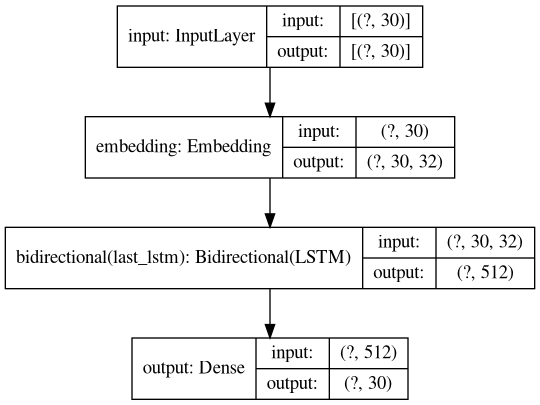

In [12]:
#Tone Tagger
tone_tagger = ToneTagger()
# tone_tagger.model_tone.summary()
tf.keras.utils.plot_model(tone_tagger.model_tone, to_file='/tmp/model_tone.png', show_shapes=True, show_layer_names=True)

In [13]:
for verse in divine_comedy.split('\n')[:11]:
    for w in verse.split():
        if w not in special_tokens.values():
            print(tone_tagger.tone(w), flush=True, end=' ')
        else:
            print(w, flush=True, end=' ')
    print('')


<start_of_canto> 
<start_of_terzina> 
nel <word_sep> mèzzo <word_sep> del <word_sep> cammìn <word_sep> di <word_sep> nòstra <word_sep> vìta <end_of_verso> 
mi <word_sep> ritrovài <word_sep> per <word_sep> ùna <word_sep> sèlva <word_sep> oscùra <end_of_verso> 
ché <word_sep> la <word_sep> dirìtta <word_sep> vìa <word_sep> èra <word_sep> smarrìta <end_of_verso> 
<end_of_terzina> 
<start_of_terzina> 
àhi <word_sep> quànto <word_sep> a <word_sep> dir <word_sep> quàl <word_sep> èra <word_sep> è <word_sep> còsa <word_sep> dùra <end_of_verso> 
èsta <word_sep> sèlva <word_sep> selvàggia <word_sep> e <word_sep> àspra <word_sep> e <word_sep> fòrte <end_of_verso> 
che <word_sep> nel <word_sep> pensièr <word_sep> rinòva <word_sep> la <word_sep> paùra <end_of_verso> 
<end_of_terzina> 


This ToneNetwork learns an embedding for each character in input and by visualizing the characters into the embedding space we can see a separation between toned vowels, vowels and consonants.

In [6]:
from tensorboard.plugins import projector
%load_ext tensorboard
# Set up a logs directory, so Tensorboard knows where to look for files
log_dir=os.path.join('/tmp', 'emb_visual_tensorboard')
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for char in tone_tagger.char2idx.keys():
        f.write('"{}"\n'.format(char))

# Save the weights we want to analyse as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, so
# we will remove that value.
weights = tf.Variable(tone_tagger.model_tone.get_layer('embedding').get_weights()[0])
# Create a checkpoint from embedding, the filename and key are
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [7]:
%tensorboard --logdir /tmp/emb_visual_tensorboard/

Reusing TensorBoard on port 6006 (pid 233777), started 0:04:20 ago. (Use '!kill 233777' to kill it.)

### Syllabified text

In [14]:
divine_comedy = clean_and_tone_comedy(divine_comedy, special_tokens)
for verse in divine_comedy.split('\n')[:11]:
    syllables = syllabify_verse(verse, special_tokens)
    print(syllables, flush=True)

['<start_of_canto>']
['<start_of_terzina>']
['nel', '<word_sep>', 'mèz', 'zo', '<word_sep>', 'del', '<word_sep>', 'cam', 'mìn', '<word_sep>', 'di', '<word_sep>', 'nò', 'stra', '<word_sep>', 'vì', 'ta', '<end_of_verso>']
['mi', '<word_sep>', 'ri', 'tro', 'vài', '<word_sep>', 'per', '<word_sep>', 'ù', 'na', '<word_sep>', 'sèl', 'va<word_sep>o', 'scù', 'ra', '<end_of_verso>']
['ché', '<word_sep>', 'la', '<word_sep>', 'di', 'rìt', 'ta', '<word_sep>', 'vì', 'a<word_sep>è', 'ra', '<word_sep>', 'smar', 'rì', 'ta', '<end_of_verso>']
['<end_of_terzina>']
['<start_of_terzina>']
['àhi', '<word_sep>', 'quàn', 'to<word_sep>a', '<word_sep>', 'dir', '<word_sep>', 'quàl', '<word_sep>', 'è', 'ra<word_sep>è', '<word_sep>', 'cò', 'sa', '<word_sep>', 'dù', 'ra', '<end_of_verso>']
['è', 'sta', '<word_sep>', 'sèl', 'va', '<word_sep>', 'sel', 'vàg', 'gia<word_sep>e<word_sep>à', 'spra', '<word_sep>', 'e', '<word_sep>', 'fòr', 'te', '<end_of_verso>']
['che', '<word_sep>', 'nel', '<word_sep>', 'pen', 'sièr', '<

### BUILDING DATASETS

### Divine Comedy rhymes

In [9]:
# text_in_syls_rhyme_file = os.path.join(working_dir, 'text_in_syls_rhyme.json')

# if os.path.isfile(text_in_syls_rhyme_file):
#     syls_rhyme_list = load_syls_list(text_in_syls_rhyme_file)
    
    
syls_rhyme_list = text_in_syls_rhyme(divine_comedy)
    
    
for syl in syls_rhyme_list[:23]:
    print(syl, flush=True, end=' ')
    if syl in special_tokens.values():
        print('')

<start_of_canto> 
<start_of_terzina> 
vì ta <end_of_verso> 
scù ra <end_of_verso> 
rì ta <end_of_verso> 
<end_of_terzina> 
<start_of_terzina> 
dù ra <end_of_verso> 
fòr te <end_of_verso> 
ù ra <end_of_verso> 
<end_of_terzina> 


### Reversed Divine Comedy verses

In [10]:
# text_in_syls_verse_file = os.path.join(working_dir, 'text_in_syls_verse.json')

# if os.path.isfile(text_in_syls_verse_file):
#     syls_verse_list = load_syls_list(text_in_syls_verse_file)
    
syls_verse_list = text_in_rev_syls(divine_comedy)

for syl in syls_verse_list[:101]:
    if syl == '<end_of_verso>':
        print('\n')
    print(syl, flush=True, end=' ')




<end_of_verso> ta vì <word_sep> stra nò <word_sep> di <word_sep> mìn cam <word_sep> del <word_sep> zo mèz <word_sep> nel 

<end_of_verso> ra scù va<word_sep>o sèl <word_sep> na ù <word_sep> per <word_sep> vài tro ri <word_sep> mi 

<end_of_verso> ta rì smar <word_sep> ra a<word_sep>è vì <word_sep> ta rìt di <word_sep> la <word_sep> ché 

<end_of_verso> ra dù <word_sep> sa cò <word_sep> ra<word_sep>è è <word_sep> quàl <word_sep> dir <word_sep> to<word_sep>a quàn <word_sep> àhi 

<end_of_verso> te fòr <word_sep> e <word_sep> spra gia<word_sep>e<word_sep>à vàg sel <word_sep> va sèl <word_sep> sta è 

<end_of_verso> ra ù pa <word_sep> la <word_sep> va nò ri <word_sep> sièr pen <word_sep> nel <word_sep> che 